In [ ]:
!pip cache purge

In [ ]:
!pip uninstall -y pyreflect

In [ ]:
!pip install -i https://test.pypi.org/simple/ pyreflect==1.2.9

In [ ]:
!pip show pyreflect

## Generate Refl1d NR SLD profile Curves

In [30]:
import pyreflect
from pyreflect.input import NRSLDDataProcessor
from pyreflect.flows import nr_predict_sld
from pyreflect.models import (
VariationalAutoencoder, 
Autoencoder, 
train_ae, 
train_vae,
NRSLDCurvesGeneratorParams
)
import numpy as np
import torch

In [2]:
root= "./"
to_be_saved_nr_file = "data/curves/refl_nr_curves_poly.npy"
to_be_saved_sld_file = "data/curves/refl_sld_curves_poly.npy"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
config = pyreflect.config.load_config(root)

## Generate NR SLD profile curves

In [ ]:
generator_params = NRSLDCurvesGeneratorParams(
    root=root,
    mod_nr_file = to_be_saved_nr_file,
    mod_sld_file = to_be_saved_sld_file,
    num_curves = 100000,
    num_film_layers = 6 #Test with different film layers material
)

In [ ]:

#save nr, sld file
nr_arr, sld_arr = nr_predict_sld.generate_nr_sld_curves(generator_params)
nr_arr.shape,sld_arr.shape

### Load Refl1d data

In [3]:
dproc = NRSLDDataProcessor(
    nr_file_path = to_be_saved_nr_file,
    sld_file_path = to_be_saved_sld_file).load_data()



### Preprocessing & Train Test Split

In [5]:
expt_nr_arr = dproc.normalize_nr()
expt_sld_arr = dproc.normalize_sld()

#Train Test Split 
list_arrays = dproc.split_arrays(expt_nr_arr,expt_sld_arr, size_split=0.7)

tensor_arrays = dproc.convert_tensors(list_arrays)

# Dataloaders for training 
tr_data, val_data,tst_data, tr_load, val_load,tst_load = dproc.get_dataloaders(*tensor_arrays,16)


In [6]:
tr_norm_stats = dproc.get_normalization_stats()
tr_norm_stats

{'nr': {'x': {'min': np.float64(0.008101436040354381),
   'max': np.float64(0.1975709062238298)},
  'y': {'min': np.float64(-8.0), 'max': np.float64(3.288356660946585e-14)}},
 'sld': {'x': {'min': np.float64(0.0), 'max': np.float64(932.0999999999967)},
  'y': {'min': np.float64(0.000892426447016592),
   'max': np.float64(4.952560920425859)}}}

### VAE Training

In [7]:
class FlattenedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return x.view(-1), y  # flatten input

In [12]:

class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [8]:
tr_load = torch.utils.data.DataLoader(
    FlattenedDataset(tr_data), batch_size=16, shuffle=False
)

val_load = torch.utils.data.DataLoader(
    FlattenedDataset(val_data), batch_size=16, shuffle=False
)

#Check batch shape for training
batch = next(iter(tr_load))

batch_x, batch_y = batch
x,_ = tr_data[0]

x.numel(),batch_x.shape,batch_y.shape


/tmp/ipykernel_164609/2441209925.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/tmp/ipykernel_164609/2441209925.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


(616, torch.Size([16, 616]), torch.Size([16, 2, 900]))

In [9]:
#The first sample input
latent_dims = 16 # AE latent dimention
init_size = x.numel() # AE input size

model = Autoencoder(init_size, latent_dims).to(device)
train_loss, val_loss = train_ae(
    model,
    tr_load,
    val_load,
    epochs=10, 
    loss_fn=torch.nn.MSELoss()
)
# train_loss, val_loss = train_vae(
#     model,
#     tr_load,
#     val_load,
#     epochs=10, 
#     beta=0.8
# )

/tmp/ipykernel_164609/2441209925.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/tmp/ipykernel_164609/2441209925.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Epoch: 1, train loss: 0.0011052357804429318, valid loss: 0.0007981962597207117
Epoch: 2, train loss: 0.0006421772539549108, valid loss: 0.0005675838558501733
Epoch: 3, train loss: 0.0004945127910003066, valid loss: 0.0003828932928020206
Epoch: 4, train loss: 0.0003503031600000603, valid loss: 0.0003478244496495781
Epoch: 5, train loss: 0.00031134601847069074, valid loss: 0.0002787570692758922
Epoch: 6, train loss: 0.0002482327407808043, valid loss: 0.00020359084763317686
Epoch: 7, train loss: 0.00017433926093425334, valid loss: 0.00015051513994378206
Epoch: 8, train loss: 0.00013646740876304517, valid loss: 0.00013449961511129792
Epoch: 9, train loss: 0.0001243234764751313, valid loss: 0.00011969459437227039
Epoch: 10, train loss: 0.0001178526316045983, valid loss: 0.00010966026314299927


### Experimental data - NR

## load expt .dat from folder
- fit_REF_L_ID.dat
- sld_REF_L_ID.dat

In [31]:
import numpy as np
import glob
import os
import re

# Folder containing the files
folder_path = "./data/curves/expt"

# Find all fit and sld files
fit_files = glob.glob(os.path.join(folder_path, "fit_*.dat"))
sld_files = glob.glob(os.path.join(folder_path, "sld_*.dat"))

# Helper to extract number ID from filename
def extract_id(filename):
    match = re.search(r'_(\d+)\.dat$', filename)
    return match.group(1) if match else None

# Create maps from number_id to filename
fit_map = {extract_id(f): f for f in fit_files}
sld_map = {extract_id(f): f for f in sld_files}

# Get sorted list of matching IDs (intersection)
common_ids = sorted(set(fit_map) & set(sld_map))

# Load data into arrays (aligned by matching ID)
fit_data_list = [np.loadtxt(fit_map[i]) for i in common_ids]
sld_data_list = [np.loadtxt(sld_map[i]) for i in common_ids]

# Convert to arrays (if all shapes match)
try:
    fit_array = np.stack(fit_data_list)
    sld_array = np.stack(sld_data_list)
except ValueError:
    print("Files have mismatched shapes. Keeping as lists.")
    fit_array = fit_data_list
    sld_array = sld_data_list


print(f"Loaded {len(common_ids)} matching file pairs.")

Files have mismatched shapes. Keeping as lists.
Loaded 8 matching file pairs.


In [32]:
# Prepare NR curves
combined_nr = []
for arr in fit_array:
    trimmed = arr.T[:, :308]
    combined_nr.append(trimmed)

combined_nr = np.stack(combined_nr)
combined_nr.shape


(8, 2, 308)

In [34]:
# Prepare SLD profile curves
combined_sld = []
for sld in sld_array:
    combined_sld.append(sld.T)

data = combined_sld
# # Step 1: Find max length
# max_len = max(len(arr) for row in data for arr in row)

# # Step 2: Create zero-padded array
# padded = np.zeros((len(data), 2, max_len), dtype=np.float32)

# for i, row in enumerate(data):
#     for j, arr in enumerate(row):
#         padded[i, j, :len(arr)] = arr
        
# clipped_sld = padded[:, :, :900]

### Save processed Expt data

In [35]:
folder = './data/curves/expt'
combined_nr_file = "./data/curves/expt/combined_nr.npy"
combined_sld_file = "./data/curves/expt/combined_sld.npy"

In [38]:
data = [np.array(x) for x in data]  # make sure all elements are arrays
obj_array = np.empty(len(data), dtype=object)
for i, arr in enumerate(data):
    obj_array[i] = arr

np.save(combined_sld_file, obj_array, allow_pickle=True)

In [29]:
np.save(combined_sld_file,clipped_data)
np.save(combined_nr_file,combined_nr)

### Load Expt Data - expt nr, expt sld

In [21]:
tst_dproc = NRSLDDataProcessor(
    nr_file_path = combined_nr_file,
    sld_file_path = combined_sld_file
).load_data()

norm_tst_nr=tst_dproc.normalize_nr(norm_stats = tr_norm_stats['nr'])
norm_tst_sld = tst_dproc.normalize_sld(norm_stats = tr_norm_stats['sld'])
norm_tst_nr.shape, norm_tst_sld.shape

In [15]:
from torch.utils.data import Dataset, DataLoader
base_dataset = NumpyDataset(norm_tst_nr, norm_tst_sld)

# Wrap it with FlattenedDataset
flat_dataset = FlattenedDataset(base_dataset)

# Create DataLoader
tst_load = DataLoader(flat_dataset, batch_size=16, shuffle=True)


In [16]:
#reconstruct Test Load
model.eval()
denoised_all = []

x_load = tst_load

with torch.no_grad():
    for batch in x_load:
        inputs, _ = batch  # ignore labels if present
        inputs = inputs.to(device)

        outputs = model(inputs)  # This calls forward() internally
        #reshape back to 2d
        outputs = outputs.view(outputs.size(0), 2, -1) # (B, 2, M)
        denoised_all.append(outputs.cpu())

denoised_all = torch.cat(denoised_all, dim=0).numpy()
denoised_all.shape, type(denoised_all)

((8, 2, 308), numpy.ndarray)

In [ ]:
np.save("./data/curves/ae_recon_nr_ldim16.npy",denoised_all)
np.save("./data/curves/ae_recon_sld_ldim16.npy",tst_dproc._sld_arr)

In [27]:
denorm_denoised_nr = tst_dproc.denormalize(denoised_all,curve_type='nr',min_max_stats = tr_norm_stats['nr'])


In [28]:
np.save("./data/curves/expt/combined_expt_denoised_nr.npy",denorm_denoised_nr)

In [17]:
import matplotlib.pyplot as plt

def plot_experiment_results(orig_nr_data, ae_nr_data=None):

    fig, ax = plt.subplots(1, figsize=(12, 5))

    # Plotting curves on a single axis
    ax.plot(orig_nr_data[0], orig_nr_data[1], 'b-', label="Original NR", alpha=0.7)
    if ae_nr_data is not None:
        ax.plot(ae_nr_data[0], ae_nr_data[1], 'g--', label="AE NR", linewidth=2)
    
    ax.set_xlabel("Q (1/Å)")
    ax.set_ylabel("Reflectivity", color="blue")
    ax.set_yscale("log")
    ax.set_title("Experimental NR Data")
    ax.legend()
    
    plt.tight_layout()
    plt.show()

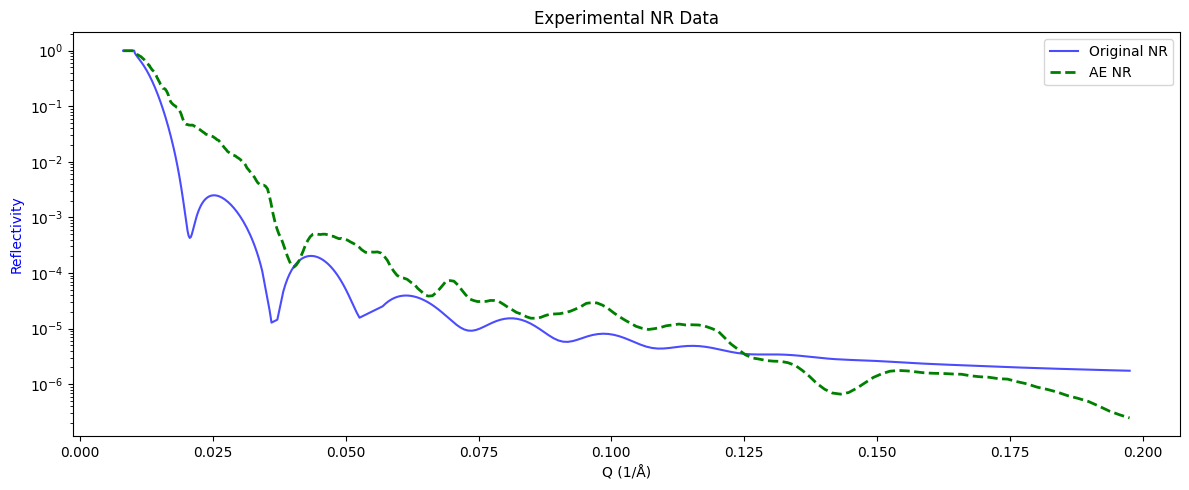

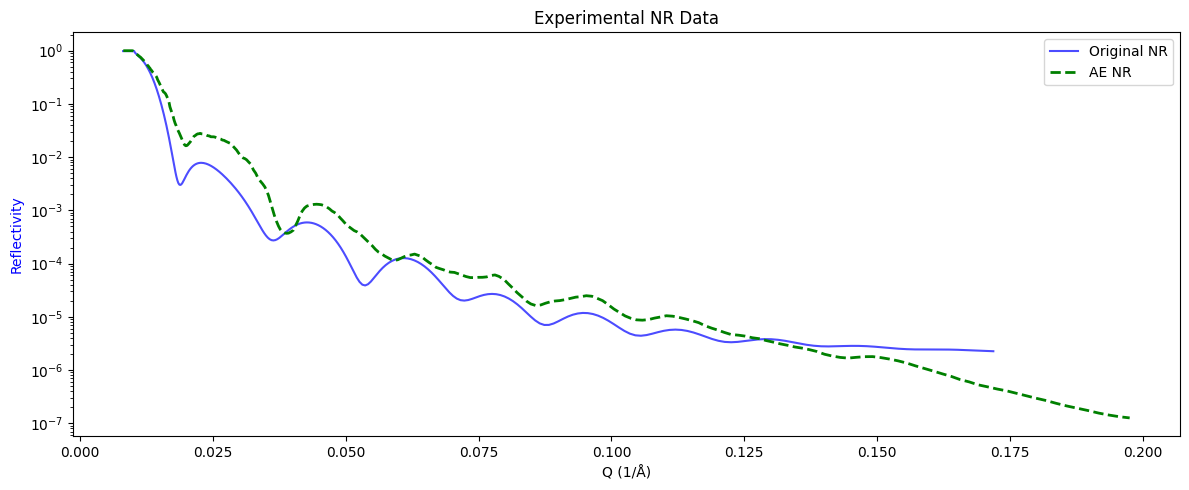

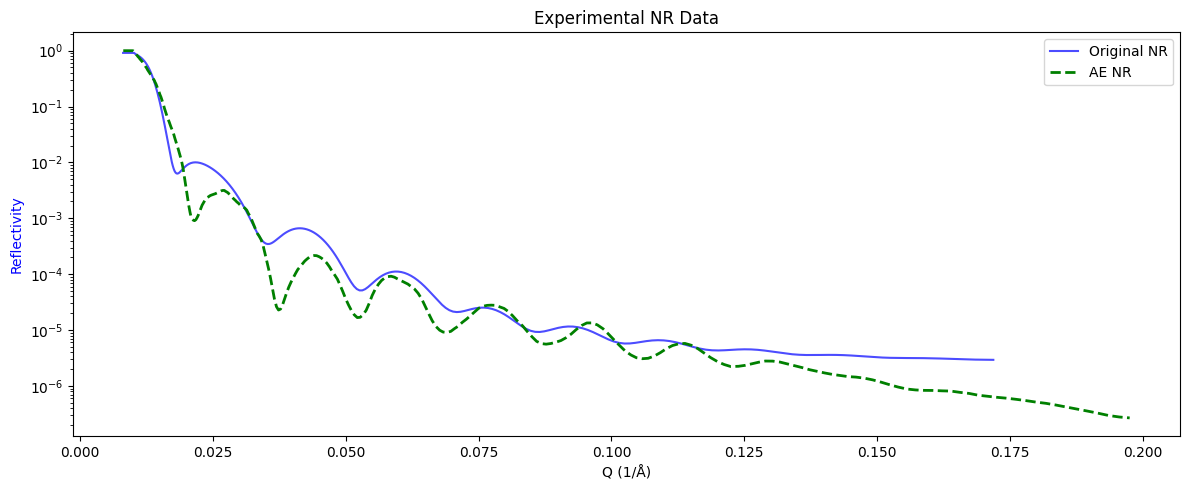

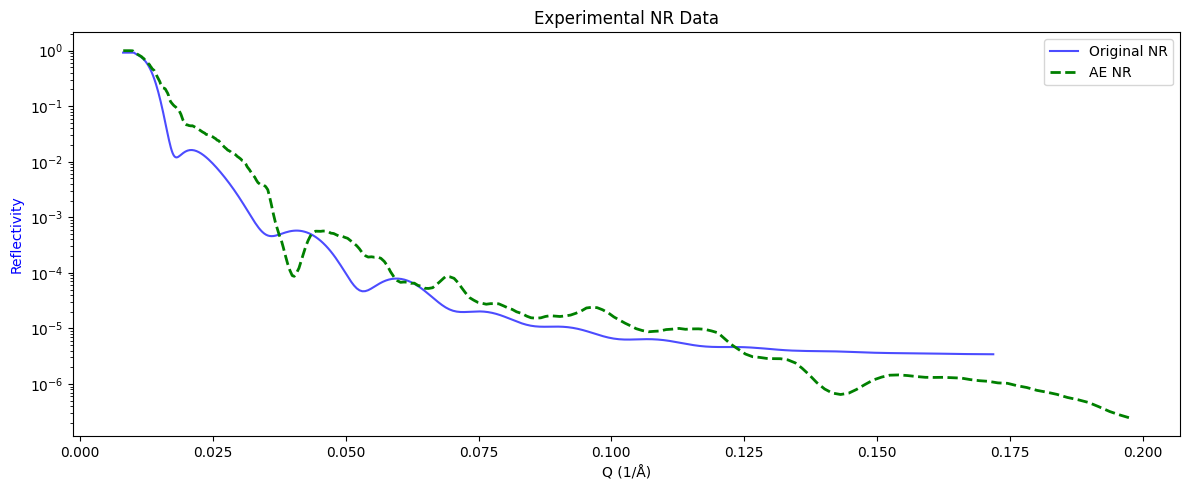

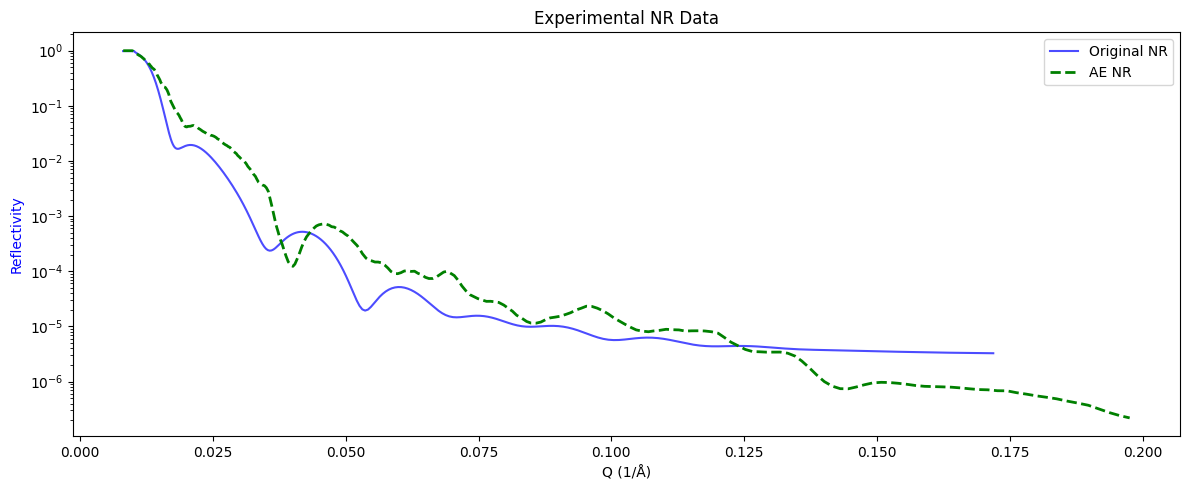

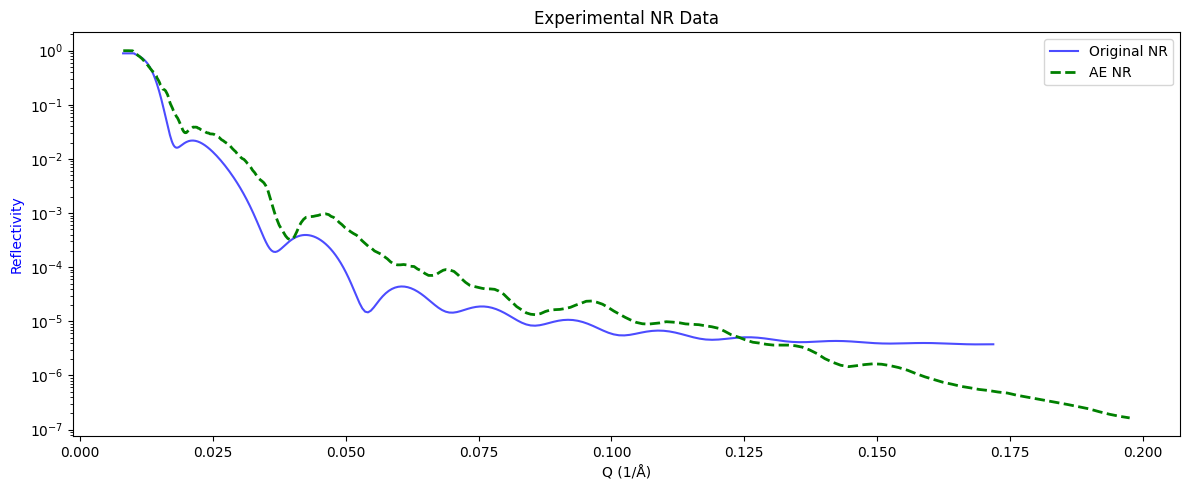

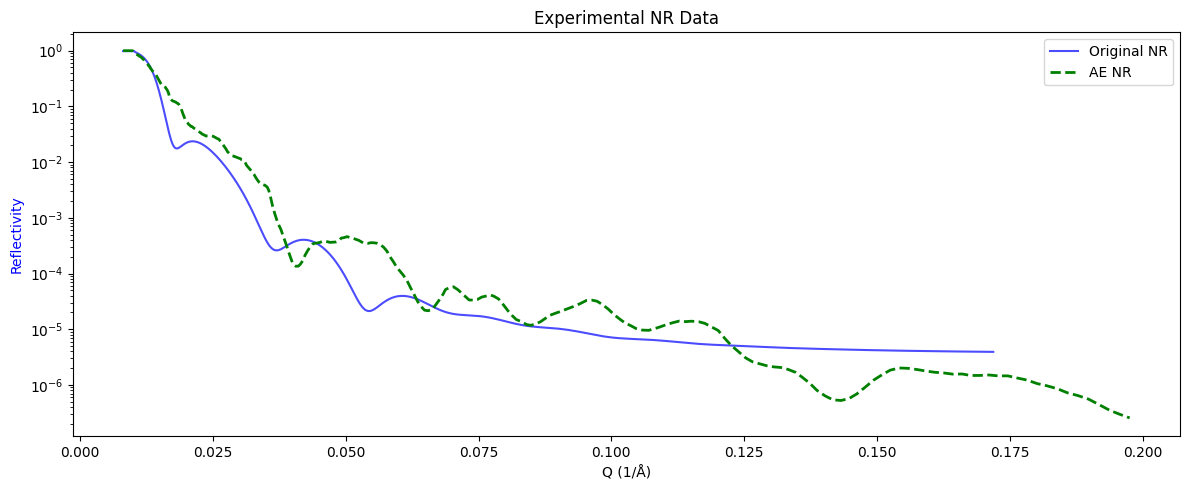

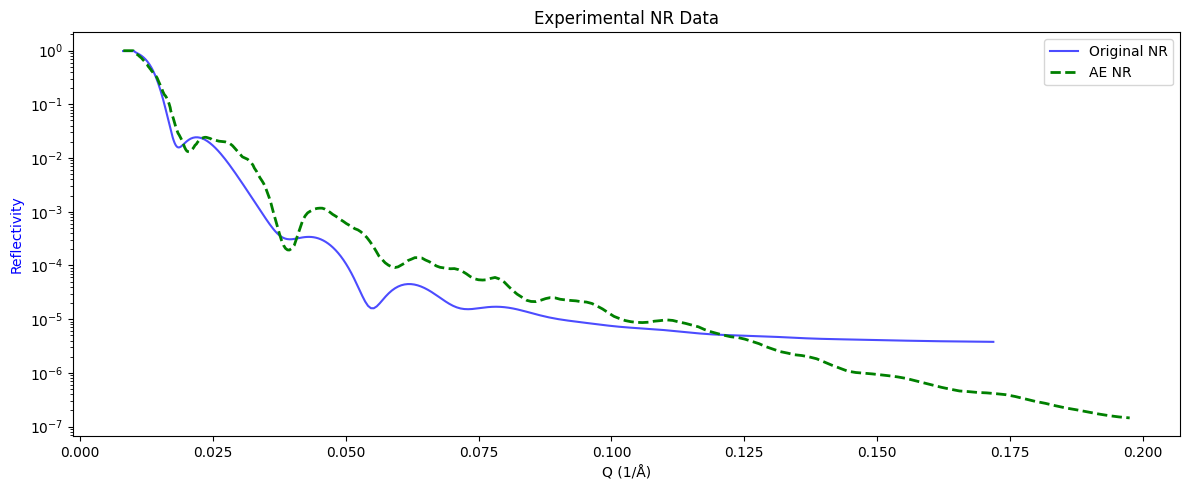

In [29]:
for orig_nr, ae_nr in zip(tst_dproc._nr_arr,denorm_denoised_nr):
    plot_experiment_results(orig_nr,ae_nr)